# ***Projet de : Speech Emotion Recognition***

<hr color="blue">

##<font color="#8accf1"> ***Step 1: Import the necessary libraries***

In [ ]:
from google.colab import files
import zipfile
import os
import glob
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from IPython.display import Audio, display
import librosa.display
import shutil
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import StandardScaler

<hr color="blue">

##<font color="#8accf1"> ***Step 2 :Upload Dataset from Kaggle***</font>

###<font color="#8aecf1">***2.1 Configure the Kaggle API in Colab***</font>


In [ ]:
#Upload the kaggle.json file to Google Colab
files.upload()

In [ ]:
# create a hidden .keggle directory and move my kaggle.json file into it:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the kaggle.json file (replace aaa with a number)
!chmod aaa ~/.kaggle/kaggle.json

<font color="#8a8ff1">***Comments***:

* *In the codes above*, *I prepared my environment to interact with* *the API of my kaggle account* .

* *Moving the Kaggle*.*json file to the hidden* .*kaggle directory helps secure my account authentication information*, *which reduces the risk of unauthorized access*.
* *Afterwards*, *I modified the user information to use my file with my own permissions*, *thus preventing any attempt to use my Kaggle credentials by an external person*.








###<font color="#8aecf1">***2.2 Upload the dataset of our project***</font>

In [ ]:
#Uploader the dataset : RAVDESS Emotional Speech Audio from kaggle using its identifier
!kaggle datasets download -d Your datataset identifier

In [ ]:
# unzip the audio file in our environment colab:
dataset_orig = '/content/ravdess-emotional-speech-audio.zip'
dataset_unziped_aud = '/content/ravdess-emotional-speech-audio'
with zipfile.ZipFile(dataset_orig, 'r') as zip_reference:
    zip_reference.extractall(dataset_unziped_aud)


In [ ]:
#List unzipped files to check file contents :
for dirname, _, filenames in os.walk(dataset_unziped_aud):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/content/ravdess-emotional-speech-audio/Actor_13/03-01-03-02-01-02-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-02-01-01-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-03-01-02-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-04-01-02-02-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-07-02-01-02-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-04-01-02-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-05-01-01-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-06-02-01-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-04-01-01-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-04-02-02-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-03-01-01-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-06-02-02-01-13.wav
/content/ravdess-emotional-speech-audio/Actor_13/03-01-08-02-01-01-13.wav
/content/ravdess-emotional-speech-audi

<hr color="blue">

##<font color="#8accf1"> ***Step 3 :Exploratory data analysis***</font>

###<font color="#8aecf1">***3.1 Showing the Number of audio files and the unique Sampling Rates***</font>

In [ ]:
# specify the subdirectories paths :
audio_files = glob.glob('/content/ravdess-emotional-speech-audio/**/*.wav', recursive=True)
#create lists to store the audio data and the sampling ratesof these audios:
audios_data=[]
sampling_rates_of_audios=[]
#load the audios files that we have in our dataset :
for audio_file in audio_files :
  data, samp_rate = librosa.load(audio_file, sr=None)
  audios_data.append(data)
  sampling_rates_of_audios.append(samp_rate)
# the number of audio file and the unique sapling rates that we have :
number_audio_files=len(audios_data)
sampling_rates_set= set(sampling_rates_of_audios)
#Results:
print('Number of audio files is :' , number_audio_files)
print(f"Unique sampling rates : {sampling_rates_set}")

Number of audio files is : 1440
Unique sampling rates : {48000}


<font color="#8a8ff1">***Comments***:

*   ***Sampling Rate :*** *The sampling rate*, *expressed in hertz (Hz)*, *is the frequency at which an audio signal is sampled to be converted into a digital format*.*It indicates how many times per second the audio data is captured*.
*  *All the audio files we analyzed use a sampling rate of 48*,*000 Hz*. *This means each audio file was sampled 48*,*000 times per second*, *which is common in professional audio and video recordings*. *So*, *there is no variability in sampling rates among the files in this dataset of audios*.





###<font color="#8aecf1">***3.2 Create a dataframe based on the information and the description of the dataset***</font>

In [ ]:
# Function to extract information from file name :
def extract_info_from_filename(file_path):
    filename = os.path.basename(file_path)
    parts = filename.split('-')
    modality = parts[0]
    vocal_channel = parts[1]
    emotion = parts[2]
    intensity = parts[3]
    statement = parts[4]
    repetition = parts[5]
    actor = parts[6].split('.')[0]

    return {
        'File Path': file_path,
        'Modality': modality,
        'Vocal Channel': vocal_channel,
        'Emotion': emotion,
        'Intensity': intensity,
        'Statement': statement,
        'Repetition': repetition,
        'Actor': actor
    }

# Create a DataFrame with the extracted information
data = [extract_info_from_filename(file) for file in audio_files]
df = pd.DataFrame(data)

# Show the first rows of the DataFrame
df

,File Path,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor
0,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,02,01,02,13
1,/content/ravdess-emotional-speech-audio/Actor_...,03,01,02,01,01,01,13
2,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,01,02,01,13
3,/content/ravdess-emotional-speech-audio/Actor_...,03,01,04,01,02,02,13
4,/content/ravdess-emotional-speech-audio/Actor_...,03,01,07,02,01,02,13
...,...,...,...,...,...,...,...,...
1435,/content/ravdess-emotional-speech-audio/Actor_...,03,01,05,02,02,01,05
1436,/content/ravdess-emotional-speech-audio/Actor_...,03,01,01,01,01,01,05
1437,/content/ravdess-emotional-speech-audio/Actor_...,03,01,01,01,01,02,05
1438,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,02,01,01,05


###<font color="#8aecf1">***3.3 Dimensions of the dataframe***</font>

In [ ]:
df.shape

(1440, 8)

###<font color="#8aecf1">***3.4 Distribution of the number of files per Emotion***</font>

In [ ]:
# show the unique values in the column Emotion :
print(df.Emotion.unique())

['03' '02' '04' '07' '05' '06' '08' '01']


In [ ]:
emotion_counts = df['Emotion'].value_counts().reset_index() # create a dataframe of occurences of emotions
emotion_counts.columns = ['Emotion', 'Number of Files'] # rename the columns of this dataframe created.
# configurate the fugure
fig = px.bar(emotion_counts, x='Emotion', y='Number of Files', text='Number of Files', title='Number of Audio Files per Emotion',
             color='Emotion')
#show the figure :
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='Emotion', yaxis_title='Number of Files', xaxis_tickangle=45)
fig.show()

###<font color="#8aecf1">***3.5 Mapping each column with its meaning***</font>

In [ ]:
#Emotion Matching Dictionary:
emotion_mapping={
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised',
}

# Emotional intensity matching dictionary:
intensity_mapping= {
    '01': 'Normal',
    '02': 'Strong'
}

# Statement matching dictionary:
statement_mapping = {
    '01': "Kids are talking by the door",
    '02': "Dogs are sitting by the door"
}

# Repeat matching dictionary
repetition_mapping = {
    '01': '1st repetition',
    '02': '2nd repetition'
}

# Add these additional columns to the DataFrame df :
df['emotion_name'] = df['Emotion'].map(emotion_mapping)
df['emotional_intensity'] = df['Intensity'].map(intensity_mapping)
df['statement'] = df['Statement'].map(statement_mapping)
df['repetition'] = df['Repetition'].map(repetition_mapping)

In [ ]:
df

,File Path,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,emotion_name,emotional_intensity,statement,repetition
0,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,02,01,02,13,Happy,Strong,Kids are talking by the door,2nd repetition
1,/content/ravdess-emotional-speech-audio/Actor_...,03,01,02,01,01,01,13,Calm,Normal,Kids are talking by the door,1st repetition
2,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,01,02,01,13,Happy,Normal,Dogs are sitting by the door,1st repetition
3,/content/ravdess-emotional-speech-audio/Actor_...,03,01,04,01,02,02,13,Sad,Normal,Dogs are sitting by the door,2nd repetition
4,/content/ravdess-emotional-speech-audio/Actor_...,03,01,07,02,01,02,13,Disgust,Strong,Kids are talking by the door,2nd repetition
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,/content/ravdess-emotional-speech-audio/Actor_...,03,01,05,02,02,01,05,Angry,Strong,Dogs are sitting by the door,1st repetition
1436,/content/ravdess-emotional-speech-audio/Actor_...,03,01,01,01,01,01,05,Neutral,Normal,Kids are talking by the door,1st repetition
1437,/content/ravdess-emotional-speech-audio/Actor_...,03,01,01,01,01,02,05,Neutral,Normal,Kids are talking by the door,2nd repetition
1438,/content/ravdess-emotional-speech-audio/Actor_...,03,01,03,02,01,01,05,Happy,Strong,Kids are talking by the door,1st repetition


<font color="#8a8ff1">***Comment***:

*To enhance my understanding of the data in the DataFrame*, *I added several additional columns using mapping dictionaries*. *These additions replace numeric codes with meaningful textual descriptions for emotions*, *emotional intensity*, *statements*,* and repetitions*. *This allows me to obtain clearer and more detailed information*.

###<font color="#8aecf1">***3.6 DataFrame Information***</font>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   File Path            1440 non-null   object
 1   Modality             1440 non-null   object
 2   Vocal Channel        1440 non-null   object
 3   Emotion              1440 non-null   object
 4   Intensity            1440 non-null   object
 5   Statement            1440 non-null   object
 6   Repetition           1440 non-null   object
 7   Actor                1440 non-null   object
 8   emotion_name         1440 non-null   object
 9   emotional_intensity  1440 non-null   object
 10  statement            1440 non-null   object
 11  repetition           1440 non-null   object
dtypes: object(12)
memory usage: 135.1+ KB


<font color="#8a8ff1">***Comment***:

*We observe that the following columns are currently classified as object*, *whereas they should be numeric data*:
*   ***Modality***
*   ***Vocal Channel***
*   ***Emotion***
*   ***Intensity***
*   ***Statement***
*   ***Repetition***
*   ***Actor***

###<font color="#8aecf1">***3.7 Convert columns to integers***</font>

In [ ]:
# Check unique values ​​to ensure columns contain only valid values ​​for conversion
print(df['Modality'].unique())
print(df['Vocal Channel'].unique())
print(df['Emotion'].unique())
print(df['Intensity'].unique())
print(df['Statement'].unique())
print(df['Repetition'].unique())
print(df['Actor'].unique())

['03']
['01']
['03' '02' '04' '07' '05' '06' '08' '01']
['02' '01']
['01' '02']
['02' '01']
['13' '07' '10' '04' '24' '23' '03' '01' '22' '20' '08' '18' '16' '06'
 '19' '21' '11' '15' '14' '02' '17' '09' '12' '05']


In [ ]:
#Convert columns to integers :
df['Modality'] = df['Modality'].astype(int)
df['Vocal Channel'] = df['Vocal Channel'].astype(int)
df['Emotion'] = df['Emotion'].astype(int)
df['Intensity'] = df['Intensity'].astype(int)
df['Statement'] = df['Statement'].astype(int)
df['Repetition'] = df['Repetition'].astype(int)
df['Actor'] = df['Actor'].astype(int)
#verifying the dataframe :
print(df.dtypes)

File Path              object
Modality                int64
Vocal Channel           int64
Emotion                 int64
Intensity               int64
Statement               int64
Repetition              int64
Actor                   int64
emotion_name           object
emotional_intensity    object
statement              object
repetition             object
dtype: object


***Now the columns types are corrects***

###<font color="#8aecf1">***3.8 Distribution of the number of files per Emotion names***</font>

In [ ]:
emotion_names_counts = df['emotion_name'].value_counts().reset_index() # create a dataframe of occurences of emotions_names
emotion_names_counts.columns = ['Emotion', 'Number of Files'] # rename the columns of this dataframe created.
# configurate the figure
fig = px.bar(emotion_names_counts, x='Emotion', y='Number of Files', text='Number of Files', title='Number of Audio Files per Emotion',
             color='Number of Files')
#show the figure :
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='Emotion', yaxis_title='Number of Files', xaxis_tickangle=45)
fig.show()


<font color="#8a8ff1">***Comment***:

*We observe that emotions such as Fearful*, ***Calm***, ***Surprised***, ***Sad***, ***Happy***, ***Disgust***, *and* ***Angry*** *are each represented by 192 audio files*. *In contrast, the emotion Neutral is represented by 96 audio files*.

###<font color="#8aecf1">***3.9 Distribution of the number of files per Emotional intensity***</font>

In [ ]:
# create a dataframe of occurences of emotional_intensity
intensity_counts = df['emotional_intensity'].value_counts().reset_index()
intensity_counts.columns = ['Intensity', 'Number of Files'] # rename the columns of this dataframe created.

# configurate the figure :
fig = px.bar(intensity_counts, x='Intensity', y='Number of Files', text='Number of Files',
             title='Number of Audio Files by Emotional Intensity',
             color='Intensity')

# show the graphe :
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_title='Emotional intensity', yaxis_title='Number of files',
                  xaxis_tickangle=-45)
fig.show()


<font color="#8a8ff1">***Comment***:

*We have 768 files with Normal intensity and 672 files with Strong intensity*.

###<font color="#8aecf1">***3.10 Checking the missing values***</font>

In [ ]:
df.isnull().sum()

,0
File Path,0
Modality,0
Vocal Channel,0
Emotion,0
Intensity,0
Statement,0
Repetition,0
Actor,0
emotion_name,0
emotional_intensity,0


###<font color="#8aecf1">***3.11 Calculate the average emotional intensity for each emotion***</font>

In [ ]:
mean_intensity = df.groupby('Emotion')['Intensity'].mean().reset_index()

In [ ]:
print(mean_intensity)

   Emotion  Intensity
0        1        1.0
1        2        1.5
2        3        1.5
3        4        1.5
4        5        1.5
5        6        1.5
6        7        1.5
7        8        1.5


<font color="#8a8ff1">***Comment***:

*The analysis shows that the average emotional intensity is consistent across most emotions*, *with a value of 1.5 for emotions coded 2 through 8*. *However*, *emotion 1 has a slightly lower average intensity of 1*.*0*. *This means that while most emotions in the dataset have similar intensity levels*, *emotion 1 is perceived with a lower intensity compared to the others*.

###<font color="#8aecf1">***3.12 Calculate descriptive statistics for each emotion***</font>

In [ ]:
stats = df.groupby('Emotion')['Intensity'].agg(['mean', 'std', 'min', 'max']).reset_index()
stats

,Emotion,mean,std,min,max
0,1,1.0,0.000000,1,1
1,2,1.5,0.501307,1,2
2,3,1.5,0.501307,1,2
3,4,1.5,0.501307,1,2
4,5,1.5,0.501307,1,2
5,6,1.5,0.501307,1,2
6,7,1.5,0.501307,1,2
7,8,1.5,0.501307,1,2


<font color="#8a8ff1">***Comment***:

*The statistical analysis of emotional intensity for each emotion reveals that emotions coded 2 through 8 have an average intensity of 1*.*5 with a standard deviation of approximately 0*.*5*. *The minimum and maximum values for these emotions are 1 and 2*, *respectively*. *In contrast*, *emotion 1 has a constant intensity of 1*.*0 with no variability*, *as indicated by a standard deviation of 0*. *This may means that most emotions have a similar range of intensity*, *while emotion 1 is more uniform and has a lower average intensity*.

In [ ]:
# Define a function to determine gender based on actor ID
def determine_gender(actor_id):
    return 'Female' if actor_id % 2 == 0 else 'Male'

# Aapply this function to each row of your DataFrame to create a new column
df['Gender'] = df['Actor'].apply(determine_gender)
df

,File Path,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,emotion_name,emotional_intensity,statement,repetition,Gender
0,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,2,1,2,13,Happy,Strong,Kids are talking by the door,2nd repetition,Male
1,/content/ravdess-emotional-speech-audio/Actor_...,3,1,2,1,1,1,13,Calm,Normal,Kids are talking by the door,1st repetition,Male
2,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,1,2,1,13,Happy,Normal,Dogs are sitting by the door,1st repetition,Male
3,/content/ravdess-emotional-speech-audio/Actor_...,3,1,4,1,2,2,13,Sad,Normal,Dogs are sitting by the door,2nd repetition,Male
4,/content/ravdess-emotional-speech-audio/Actor_...,3,1,7,2,1,2,13,Disgust,Strong,Kids are talking by the door,2nd repetition,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,/content/ravdess-emotional-speech-audio/Actor_...,3,1,5,2,2,1,5,Angry,Strong,Dogs are sitting by the door,1st repetition,Male
1436,/content/ravdess-emotional-speech-audio/Actor_...,3,1,1,1,1,1,5,Neutral,Normal,Kids are talking by the door,1st repetition,Male
1437,/content/ravdess-emotional-speech-audio/Actor_...,3,1,1,1,1,2,5,Neutral,Normal,Kids are talking by the door,2nd repetition,Male
1438,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,2,1,1,5,Happy,Strong,Kids are talking by the door,1st repetition,Male


In [ ]:
df.Gender.value_counts()

,count
Gender,
Male,720
Female,720


In [ ]:
# Calculate the number of each Emotion_name for each gender
emotion_counts = df.groupby(['Gender', 'emotion_name']).size().unstack(fill_value=0)

# results
print(emotion_counts)

emotion_name  Angry  Calm  Disgust  Fearful  Happy  Neutral  Sad  Surprised
Gender                                                                     
Female           96    96       96       96     96       48   96         96
Male             96    96       96       96     96       48   96         96


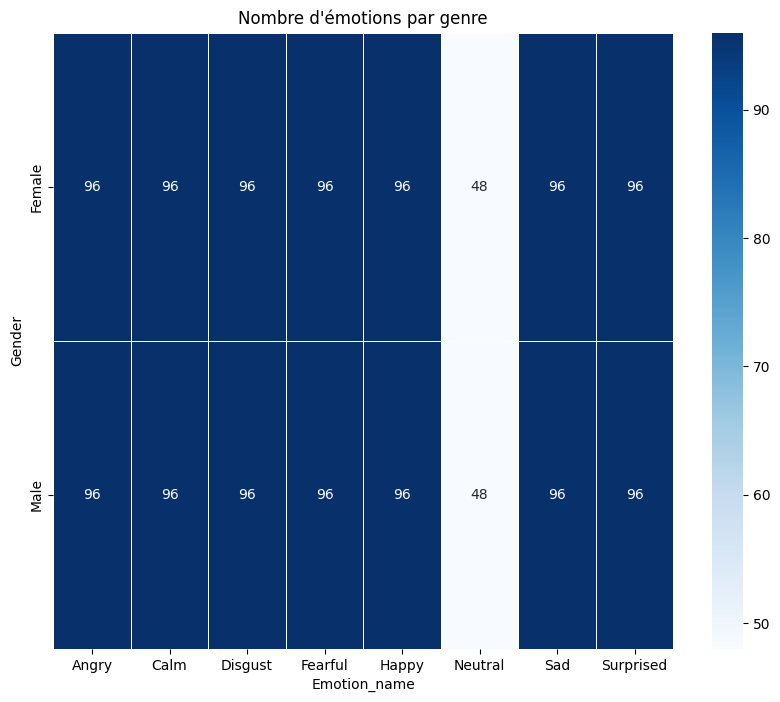

In [ ]:
# show the pivot table of each combination of gender-emotion
plt.figure(figsize=(10, 8))
sns.heatmap(emotion_counts, cmap='Blues', annot=True, fmt='d', linewidths=.5)
plt.title('Nombre d\'émotions par genre')
plt.xlabel('Emotion_name')
plt.ylabel('Gender')
plt.show()

In [ ]:
# Filter rows where 'Gender' is 'Female'
df_female = df[df['Gender'] == 'Female']
df_female

,File Path,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,emotion_name,emotional_intensity,statement,repetition,Gender
120,/content/ravdess-emotional-speech-audio/Actor_...,3,1,2,1,2,2,10,Calm,Normal,Dogs are sitting by the door,2nd repetition,Female
121,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,2,1,1,10,Happy,Strong,Kids are talking by the door,1st repetition,Female
122,/content/ravdess-emotional-speech-audio/Actor_...,3,1,4,1,1,2,10,Sad,Normal,Kids are talking by the door,2nd repetition,Female
123,/content/ravdess-emotional-speech-audio/Actor_...,3,1,2,1,1,1,10,Calm,Normal,Kids are talking by the door,1st repetition,Female
124,/content/ravdess-emotional-speech-audio/Actor_...,3,1,4,1,2,2,10,Sad,Normal,Dogs are sitting by the door,2nd repetition,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,/content/ravdess-emotional-speech-audio/Actor_...,3,1,7,2,1,1,12,Disgust,Strong,Kids are talking by the door,1st repetition,Female
1376,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,1,2,2,12,Happy,Normal,Dogs are sitting by the door,2nd repetition,Female
1377,/content/ravdess-emotional-speech-audio/Actor_...,3,1,5,1,1,2,12,Angry,Normal,Kids are talking by the door,2nd repetition,Female
1378,/content/ravdess-emotional-speech-audio/Actor_...,3,1,2,1,1,2,12,Calm,Normal,Kids are talking by the door,2nd repetition,Female


In [ ]:
#filter the dataframe to show rows with male value in Gender column:
df_male = df[df['Gender']=='Male']
df_male

,File Path,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,emotion_name,emotional_intensity,statement,repetition,Gender
0,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,2,1,2,13,Happy,Strong,Kids are talking by the door,2nd repetition,Male
1,/content/ravdess-emotional-speech-audio/Actor_...,3,1,2,1,1,1,13,Calm,Normal,Kids are talking by the door,1st repetition,Male
2,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,1,2,1,13,Happy,Normal,Dogs are sitting by the door,1st repetition,Male
3,/content/ravdess-emotional-speech-audio/Actor_...,3,1,4,1,2,2,13,Sad,Normal,Dogs are sitting by the door,2nd repetition,Male
4,/content/ravdess-emotional-speech-audio/Actor_...,3,1,7,2,1,2,13,Disgust,Strong,Kids are talking by the door,2nd repetition,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,/content/ravdess-emotional-speech-audio/Actor_...,3,1,5,2,2,1,5,Angry,Strong,Dogs are sitting by the door,1st repetition,Male
1436,/content/ravdess-emotional-speech-audio/Actor_...,3,1,1,1,1,1,5,Neutral,Normal,Kids are talking by the door,1st repetition,Male
1437,/content/ravdess-emotional-speech-audio/Actor_...,3,1,1,1,1,2,5,Neutral,Normal,Kids are talking by the door,2nd repetition,Male
1438,/content/ravdess-emotional-speech-audio/Actor_...,3,1,3,2,1,1,5,Happy,Strong,Kids are talking by the door,1st repetition,Male


In [ ]:
df.to_csv('df.csv', index=False)

*********************